# DATA EXTRACTION

In [1]:
import os
import io
import gzip
import tarfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro

from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import aplpy
%matplotlib inline

In [2]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        schema = freader.writer_schema
        for packet in freader:
            yield packet
            
            
def make_dataframe(packet):
    dfc = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    dflc = pd.concat([dfc,df_prv], ignore_index=True,sort=True)
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return dflc

### Code below includes: directory making, listing # of rows in candidate, listing # nans in magnr

ztf_public_20190302     ~10 sec   7 MB<br>
ztf_public_20180809     ~40 sec    32 MB<br>
ztf_public_20190519     ~2 min    107 MB<br>
ztf_public_20181215     ~8 min    410 MB<br>
ztf_public_20180601     ~25 min    786 MB 18k retrieval 1min 54s for entry 6k<br>

In [15]:
%%time

output_dir = 'D:/@Seattle/data/ztf_public_20180809'

obj_id = []
filename = []
candidate_len = []
nan_in_magnr = []
usable = []

for fname in find_files(output_dir):
    for packet in open_avro(fname):
        dflc = make_dataframe(packet)
        obj_id.append(packet['objectId'])
        a=os.path.split(fname)[1]
        fname=os.path.splitext(a)[0]
        filename.append(fname) 
        dfc = pd.DataFrame(packet['candidate'], index=[0])
        df_prv = pd.DataFrame(packet['prv_candidates'])
        dflc = pd.concat([dfc,df_prv], ignore_index=True,sort=True)
        candidate_len.append((dflc.shape[0]))
        nan_in_magnr.append(dflc.magnr.isna().sum())
        usable.append(((dflc.shape[0])-1)-dflc.magnr.isna().sum())
        


        

#this creates directory of from output_dir
directory=pd.DataFrame(columns=['objectId','filename','candlength','# of nans [magnr]','Available'])
for i in range(len(obj_id)-1):
    directory=directory.append({'objectId':obj_id[i],
                                'filename':filename[i],
                                'candlength':candidate_len[i],
                                '# of nans [magnr]':nan_in_magnr[i],
                                'Available':usable[i]}, ignore_index=True)

directory.insert(5,"Usability",(directory['Available']/directory['candlength'])*100, True)
print('directory now available')
directory[["candlength", 
           "# of nans [magnr]",
           "Available"]] = directory[["candlength", "# of nans [magnr]","Available"]].apply(pd.to_numeric)


directory now available
Wall time: 55.3 s


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(directory)

,objectId,filename,candlength,# of nans [magnr],Available,Usability
0,ZTF18abedgrj,585152190015010001,2,1,0,0
1,ZTF18abedgrl,585152190015010002,2,0,1,50
2,ZTF18abmbbim,585152190015010003,2,1,0,0
3,ZTF18abmbbin,585152190015015006,2,1,0,0
4,ZTF18abmbbil,585152190015015014,2,1,0,0
5,ZTF18ablqgdh,585152190215010000,2,0,1,50
6,ZTF18abmbbij,585152190215010004,2,1,0,0
7,ZTF18ablqgdi,585152190215010005,2,0,1,50
8,ZTF18abmbbii,585152190215015001,2,1,0,0
9,ZTF18abmbbik,585152190215015004,2,1,0,0


In [17]:
#filter through directory
cond= (directory['candlength']> 10) & (directory['Usability'] < 10) & (directory['Usability']> 0)
#cond= (directory['Usability']> 0) & (directory['Usability']< 20)
#print(directory.index[cond].tolist())

display(directory.loc[directory.index[cond]])

#directory.loc[directory['Available'].idxmax()]


,objectId,filename,candlength,# of nans [magnr],Available,Usability
133,ZTF18abagukg,585153593515010003,13,11,1,7.69231
152,ZTF18abmbbjm,585154060015015000,14,12,1,7.14286
210,ZTF18aajscoh,585154591815010001,16,14,1,6.25
211,ZTF18aainuux,585154591815010014,16,14,1,6.25
242,ZTF18aanhest,585154593515015015,28,25,2,7.14286
248,ZTF18aaogoyn,585154594815015000,30,28,1,3.33333
266,ZTF18aajsyzd,585155060115010001,14,12,1,7.14286
269,ZTF18aamegql,585155060215015002,14,12,1,7.14286
278,ZTF18aaiybzd,585155061715010000,14,12,1,7.14286
283,ZTF18abiekpx,585155061815015011,14,12,1,7.14286


In [18]:
%%time
# retrieve data from object
n = 133
obj = directory.objectId[n] #obj from list
fn = directory.filename[n]
for fname in find_files(output_dir):
    for packet in open_avro(fname):
        dflc = make_dataframe(packet)
        if packet['objectId'] == obj:            
            dfc = pd.DataFrame(packet['candidate'], index=[0])
            df_prv = pd.DataFrame(packet['prv_candidates'])
            dflc = pd.concat([dfc,df_prv], ignore_index=True,sort=True)
            if dflc.magnr.isna().sum()>15:
                print('{} Nans in packet with {} detections. Might cause error in DC mag compute.'.format(dflc.magnr.isna().sum(),
                                                                                                          len(packet['candidate'])
                                                                                                         ))
            print('New dflc for obj: {} (f:{}) created'.format(packet['objectId'],fn))
            #print('hi')
            break 
    if packet['objectId'] == obj:   #first if only breaks from mid-for
        break




New dflc for obj: ZTF18abagukg (f:585153593515010003) created
Wall time: 2.89 s


In [19]:
#to check
fnamex = '{}/{}.avro'.format(output_dir,fn)
with open(fnamex,'rb') as f:    #read fname in binary
    freader = fastavro.reader(f)
    schema = freader.writer_schema
    for packetx in freader:
        print(packetx['objectId'])
        
dflc2 = make_dataframe(packetx)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(dflc2)

ZTF18abagukg


,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,clrcounc,clrmed,clrrms,dec,decnr,diffmaglim,distnr,distpsnr1,distpsnr2,distpsnr3,dsdiff,dsnrms,elong,fid,field,fwhm,isdiffpos,jd,jdendhist,jdendref,jdstarthist,jdstartref,magap,magapbig,magdiff,magfromlim,maggaia,maggaiabright,magnr,magpsf,magzpsci,magzpscirms,magzpsciunc,mindtoedge,nbad,ncovhist,ndethist,neargaia,neargaiabright,nframesref,nid,nmatches,nmtchps,nneg,objectidps1,objectidps2,objectidps3,pdiffimfilename,pid,programid,programpi,ra,ranr,rb,rbversion,rcid,rfid,scorr,seeratio,sgmag1,sgmag2,sgmag3,sgscore1,sgscore2,sgscore3,sharpnr,sigmagap,sigmagapbig,sigmagnr,sigmapsf,simag1,simag2,simag3,sky,srmag1,srmag2,srmag3,ssdistnr,ssmagnr,ssnamenr,ssnrms,sumrat,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed
0,0.522,0.428025,0.337,0.276330,585153593515010003,1.025,383.356415,0.998,0.103681,0.000007,0.583,0.30546,19.760815,19.760842,20.014652,0.099470,0.104987,2.617063,4.772037,-48.840363,410.804382,1.548961,2,583.0,1.219556,f,2.458340e+06,2.458340e+06,2.458259e+06,2.458283e+06,2.458187e+06,15.7650,15.7229,0.219991,4.249651,12.910907,12.910907,12.877,15.545009,26.197008,0.039381,0.000004,173.818802,0.0,32.0,5.0,0.049177,0.049177,15.0,585.0,846.0,12.0,10.0,1.317124e+17,1.317124e+17,1.317124e+17,ztf_20180809153600_000583_zr_c09_o_q4_scimrefd...,585153593515,1,Kulkarni,241.859829,241.859822,0.233333,t8_f5_c3,35.0,583120235.0,8.303252,2.0,13.392,-999.0,19.535299,0.960625,0.5,0.5,0.053,0.0164,0.0170,0.023,0.206515,12.793,15.3419,-999.0,0.931649,12.975,15.5218,-999.0,-999,-999,null,459.644745,0.490758,12.699,15.1469,18.6931,3.0,0.0,173.818802,739.448608,-0.000005,26.261
1,NaN,NaN,NaN,NaN,585153593515010003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.633600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,None,2.458312e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/ztf/archive/sci/2018/0712/188322/ztf_20180712...,557188733515,1,Kulkarni,NaN,NaN,NaN,t8_f5_c3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,585153593515010003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.664301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,None,2.458312e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/ztf/archive/sci/2018/0712/189641/ztf_20180712...,557189654615,1,Kulkarni,NaN,NaN,NaN,t8_f5_c3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.652,0.499297,0.417,0.319336,585153593515010003,1.025,646.106018,0.998,NaN,NaN,NaN,NaN,19.760824,19.760842,19.908600,0.148338,NaN,NaN,NaN,NaN,NaN,1.563550,2,583.0,1.305840,f,2.458315e+06,NaN,NaN,NaN,NaN,15.3709,15.3515,0.306134,4.537650,NaN,NaN,12.877,15.064800,NaN,NaN,NaN,167.983002,0.0,NaN,NaN,NaN,NaN,NaN,560.0,NaN,NaN,13.0,NaN,NaN,NaN,/ztf/archive/sci/2018/0715/168611/ztf_20180715...,560168943515,1,Kulkarni,241.859859,241.859822,0.280000,t8_f5_c3,35.0,NaN,7.583760,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.053,0.0115,0.0122,0.023,0.176262,NaN,NaN,NaN,0.051591,NaN,NaN,NaN,None,None,None,NaN,0.575253,NaN,NaN,NaN,6.0,NaN,167.983002,458.341003,NaN,NaN
4,NaN,NaN,NaN,NaN,585153593515010003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.601299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,None,2.458322e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/ztf/archive/sci/2018/0722/211539/ztf_20180722...,567211574615,1,Kulkarni,NaN,NaN,NaN,t8_f5_c3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,585153593515010003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.618999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,None,2.458325e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# + DC MAGNITUDE


In [20]:
display(dflc.loc[0,['distpsnr1','sgscore1']])   #determine if nearest PS1 sourse coincident and stellar
                                        #distpsnr1 = Distance of closest source from PS1 catalog; if exists within 30 arcsec [arcsec]
                                        #sgscore1 = Star/Galaxy score. higher score = higher chance of being a star
display(dflc['distnr'])   #confirm that the nearest reference source from ZTF is also coincident
display(dflc[['magnr','sigmagnr']])   #If only upper limits (previous detection)--infer thru other observations, if possible.  
                            #`magnr` will depend on the field, chip x quadrant (`rcid`), and filter.
# convert isdiffpos into a +/- 1 value.  isdiffpos is None for nondetections

distpsnr1    0.104987
sgscore1     0.960625
Name: 0, dtype: object

0     0.099470
1          NaN
2          NaN
3     0.148338
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
Name: distnr, dtype: float64

,magnr,sigmagnr
0,12.877,0.023
1,NaN,NaN
2,NaN,NaN
3,12.877,0.023
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [21]:
def get_dcmag(dflc, match_radius_arcsec=1.5, star_galaxy_threshold = 0.4,band=2):
    if (dflc.loc[0,'distpsnr1'] > match_radius_arcsec) & (dflc.loc[0,'sgscore1'] < star_galaxy_threshold):
        print('Object is not a variable star.')
                
    else:
        dflc=dflc.fillna(np.nan)
        def robust_median(x):
            if len(x) == 0:
                return np.nan
            else:
                return np.median(x[np.isfinite(x)])
        grp = dflc.groupby(['fid','field','rcid'])
        impute_magnr = grp['magnr'].agg(robust_median)
        #print(impute_magnr)
        impute_sigmagnr = grp['sigmagnr'].agg(robust_median)
        #print(impute_sigmagnr)
        for idx, grpi in grp:
            w = np.isnan(grpi['magnr'])
            w2 = grpi[w].index
            dflc.loc[w2,'magnr'] = impute_magnr[idx]
            dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]
        dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1
        
        dflc['dc_mag'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf']))   #u
        dflc['dc_sigmag'] = np.sqrt(
            (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
            (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf']) #u
        dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))   #v
        dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))   #v2
        
        def band_amplitude(dflc, band=2):
            z = dflc[dflc.fid==band]
            ampli=z['magpsf'].max()-z['magpsf'].min()
            print('Max:',z['magpsf'].max())
            print('Min:',z['magpsf'].min())
            print('Amplitude:',ampli)
            print('Is amplitude > 1.0 mag?',ampli>=1)
            return ampli
        
        #band_amplitude(dflc)
            
        ans = None
        if band_amplitude(dflc) <=1:
            while ans not in('Y','N'):
                ans = input('Keep data? Y/N:')
                if ans == 'N':
                    break
                elif ans == 'Y':
                     continue 
                else:
                    print('Y/N:')
        
        if ans=='Y' or band_amplitude(dflc)>=1:            
            def plot_dc_lightcurve(dflc, days_ago=True):

                plt.rcParams["figure.figsize"] = (10,7)

                filter_color = {1:'green', 2:'red', 3:'pink'}
                if days_ago:
                    now = Time.now().jd
                    t = dflc.jd - now
                    xlabel = 'Days Ago'
                else:
                    t = dflc.jd
                    xlabel = 'Time (JD)'

                plt.figure()
                for fid, color in filter_color.items():
                    # plot detections in this filter:
                    w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
                    if np.sum(w):
                        plt.errorbar(t[w],dflc.loc[w,'dc_mag'], dflc.loc[w,'dc_sigmag'],fmt='.',color=color)
                    wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
                    if np.sum(wnodet):
                        plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_ulim'], marker='v',color=color,alpha=0.25)
                        plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_llim'], marker='^',color=color,alpha=0.25)


                plt.gca().invert_yaxis()
                plt.xlabel(xlabel)
                plt.ylabel('Magnitude')


            ans = None
            while ans not in('Y','N'):
                ans = input('Plot data? Y/N:')
                if ans == 'Y':
                    plot_dc_lightcurve(dflc)
                elif ans == 'N':
                    return
                else:
                    print('Y/N:')
            
            

            

Max: 15.545008659362793
Min: 15.064800262451172
Amplitude: 0.4802083969116211
Is amplitude > 1.0 mag? False
Keep data? Y/N:Y
Plot data? Y/N:Y


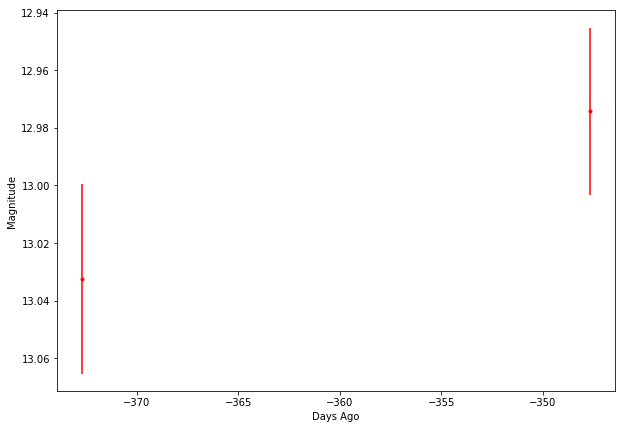

In [22]:
#dflc.iloc[0:7]
get_dcmag(dflc)

C:\Users\Mikha_PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Mikha_PC\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max: 17.420799255371094
Min: 17.261499404907227
Amplitude: 0.1592998504638672
Is amplitude > 1.0 mag? False
Keep data? Y/N:Y
Plot data? Y/N:Y


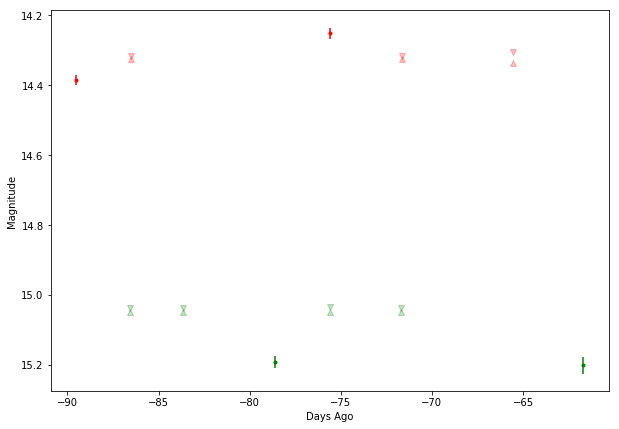

In [31]:
#test run of diff. package
get_dcmag(dflc)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

C:\Users\Mikha_PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Mikha_PC\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Mikha_PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10

### Source Code

In [29]:
def is_star(dflc, match_radius_arcsec=1.5, star_galaxy_threshold = 0.4):
    return (dflc.loc[0,'distpsnr1'] < match_radius_arcsec) & (dflc.loc[0,'sgscore1'] > star_galaxy_threshold)

print('is this a (variable) star? {}'.format(is_star(dflc)))

is this a (variable) star? True


In [ ]:
#dflc=dflc.fillna(np.nan)
def robust_median(x):
    x = x.fillna(np.nan)
    if len(x) == 0:
        return np.nan
    
    else:
        return np.median(x[np.isfinite(x)])

grp = dflc.groupby(['fid','field','rcid'])
impute_magnr = grp['magnr'].agg(robust_median)
print(impute_magnr)
impute_sigmagnr = grp['sigmagnr'].agg(robust_median)
print(impute_sigmagnr)


for idx, grpi in grp:
    w = np.isnan(grpi['magnr'])
    w2 = grpi[w].index
    dflc.loc[w2,'magnr'] = impute_magnr[idx]
    dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

In [ ]:
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1
#display(dflc['sign']) 

In [ ]:
#u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
#v = 10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim'])
#v2= 10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim'])
dflc['dc_mag'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf']))   #u
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf']) #u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))   #v
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))   #v2

In [ ]:
def band_amplitude(dflc, band=2):
    z = dflc[dflc.fid==band]
    q=z['magpsf'].max()-z['magpsf'].min()
    print('Max:',z['magpsf'].max())
    print('Min:',z['magpsf'].min())
    print('Amplitude:',q)
    print('Is amplitude > 1.0 mag?',q>=1)

band_amplitude(dflc)

In [ ]:
def plot_dc_lightcurve(dflc, days_ago=True):
    
    plt.rcParams["figure.figsize"] = (10,7)
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'dc_mag'], dflc.loc[w,'dc_sigmag'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_ulim'], marker='v',color=color,alpha=0.25)
            plt.scatter(t[wnodet],dflc.loc[wnodet,'dc_mag_llim'], marker='^',color=color,alpha=0.25)

    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    

In [ ]:
plot_dc_lightcurve(dflc)

,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,clrcounc,...,tooflag,xpos,ypos,zpclrcov,zpmed,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim
0,0.764,0.567474,0.674,0.500625,7.901713e+17,3.000,1.081154,0.894,0.612047,0.022116,...,0.0,2627.634521,537.107117,-0.012789,21.878,1,12.182574,0.054997,12.264677,12.502298
1,0.844,0.643949,0.763,0.582148,7.602021e+17,3.136,94.331596,0.997,NaN,NaN,...,NaN,2607.070068,558.843018,NaN,NaN,-1,12.938483,0.037116,12.870239,12.871762
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.870187,12.871814
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.376517,12.377483
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.870225,12.871776
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.870037,12.871964
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.376241,12.377759
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.867862,12.874148
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.375157,12.378846
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,12.373235,12.380778
